# Model Regression for Exposure At Default

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

%config IPCompleter.greedy=True

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

In [2]:

df = pd.read_pickle('../../02_Data/03_Work/df_board_ead.pickle')
x = df.drop(columns='target_ead')
y = df.target_ead



## MODEL

In [3]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

In [4]:
pipe = Pipeline([('algorithm',Ridge())])

grid = [      
        {'algorithm': [Ridge()],
         'algorithm__alpha': list(np.arange(0.1,1.1,0.1))},
        
        {'algorithm': [Lasso()],
         'algorithm__alpha': list(np.arange(0.1,1.1,0.1))},
    
        {'algorithm': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_percentage_error')],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_iter': [50,100,200],
         'algorithm__max_depth': [5,10,20],
         'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

#### Optimize hyperparameters

In [5]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [6]:
output = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(10)
output

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_algorithm__alpha,param_algorithm__l2_regularization,param_algorithm__learning_rate,param_algorithm__max_depth,param_algorithm__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,21.16,0.16,0.56,0.03,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.23,-0.23,-0.23,-0.23,0.00,1
1,22.94,0.38,0.61,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.23,-0.24,-0.24,-0.24,0.00,2
2,21.45,0.50,0.53,0.00,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,3
3,22.61,0.15,0.56,0.03,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.23,-0.24,-0.24,0.00,4
4,22.31,0.16,0.53,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,5
5,18.40,0.35,0.30,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.23,-0.24,-0.24,0.00,6
6,20.94,1.09,0.54,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,7
7,21.80,0.16,0.54,0.00,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,8
8,20.86,0.04,0.53,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,10,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,9
9,13.53,2.82,0.25,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,20,200,{'algorithm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,10


In [7]:
# result is very similar for the first configurations
# we choose the first one for simplicity

In [8]:
model_ead = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 10,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 0.75)
model_ead.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.75, max_depth=10,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_percentage_error')

### Evaluate

In [9]:
pred = model_ead.predict(val_x)

In [10]:
# correct max and min
pred = np.where(pred < 0, 0, pred)
pred = np.where(pred > 1, 1, pred)

In [11]:
mean_absolute_error(val_y, pred)

0.23459890677536505

### Report

In [12]:
check_validation = pd.DataFrame({'true_EAD':val_y, 'pred_EAD':pred})
check_validation

,true_EAD,pred_EAD
client_id,,
140444295,0.93,0.80
140293154,0.88,0.50
129914413,0.85,0.72
96487949,0.30,0.18
73691201,0.00,0.40
...,...,...
13528286,0.00,0.13
29964896,0.00,0.11
111472313,0.47,0.39


In [13]:
check_validation.corr()

,true_EAD,pred_EAD
true_EAD,1.00,0.63
pred_EAD,0.63,1.00


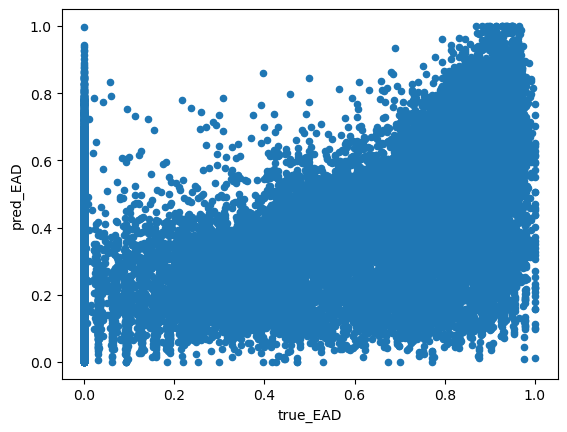

In [14]:
check_validation.plot.scatter(x='true_EAD',y='pred_EAD');

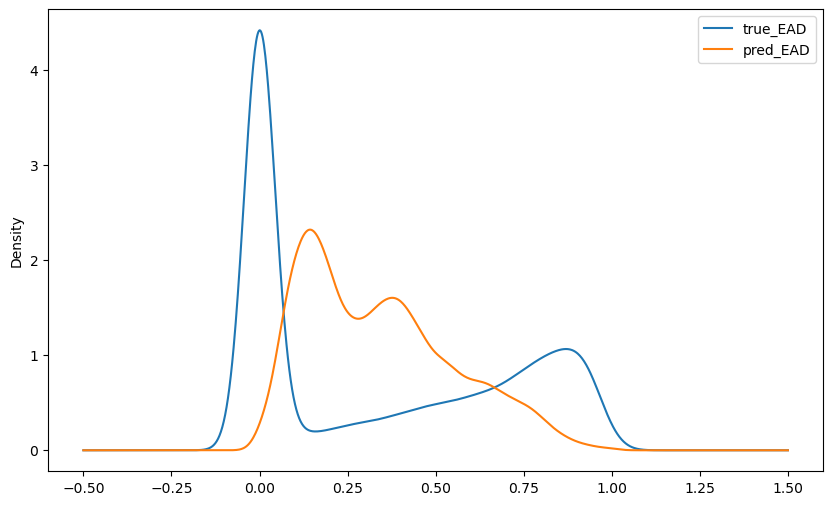

In [15]:
check_validation.plot.density(figsize = (10,6));